--- Step 1: Loading and Preparing Data ---

--- Step 2: Running Models (Degree 1 to 10) ---

             🔍 MSE RESULTS: SIMPLE TRAIN/TEST SPLIT vs. CROSS-VALIDATION
Degree      TT Train MSE     TT Test MSE     CV Mean MSE
----------------------------------------------------------------------
1        1.6931            1.5714          1.8143 ✨
2        1.6595            1.5361            1.9664
3        1.6263          1.5331 ⭐            2.6013
4        1.5670            1.6023            4.2699
5        1.4987            1.7462           74.2698
6        1.4407            2.3837         1667.8489
7        1.3408            6.7316         5806.7009
8        1.2558           15.2733      2823318.8431
9        1.1857           60.1024     40054225.4429
10       1.0571         1901.0907  25039437061.1044
----------------------------------------------------------------------
⭐ Optimal Degree (TT Split): 3 | ✨ Optimal Degree (CV): 1

--- Step 4a: Plotting and Saving Train/Test Split Curve 

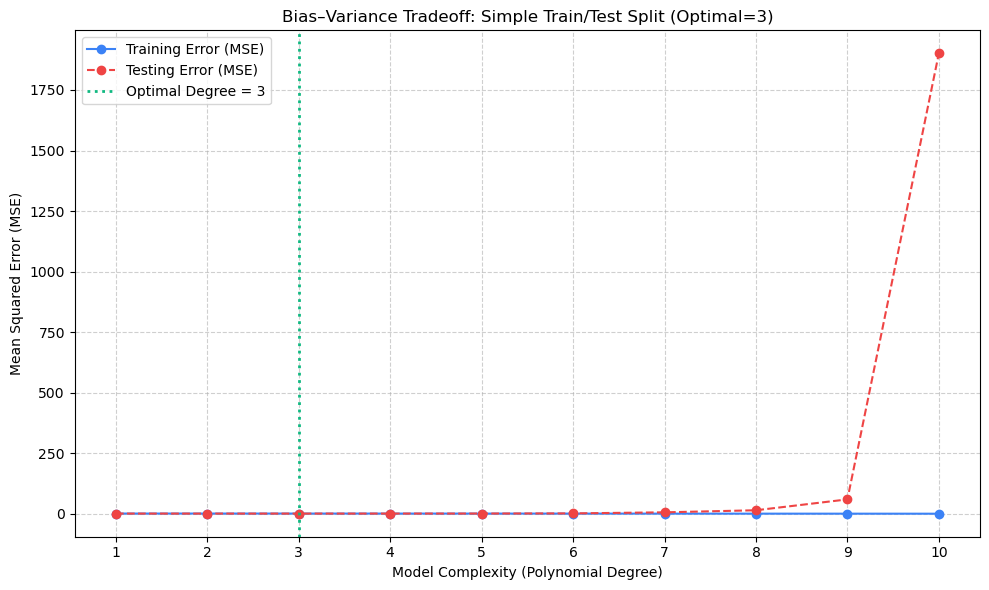


--- Step 4b: Plotting and Saving Cross-Validation Curve ---
Saved Cross-Validation plot to 'bias_variance_cv_mean.png'


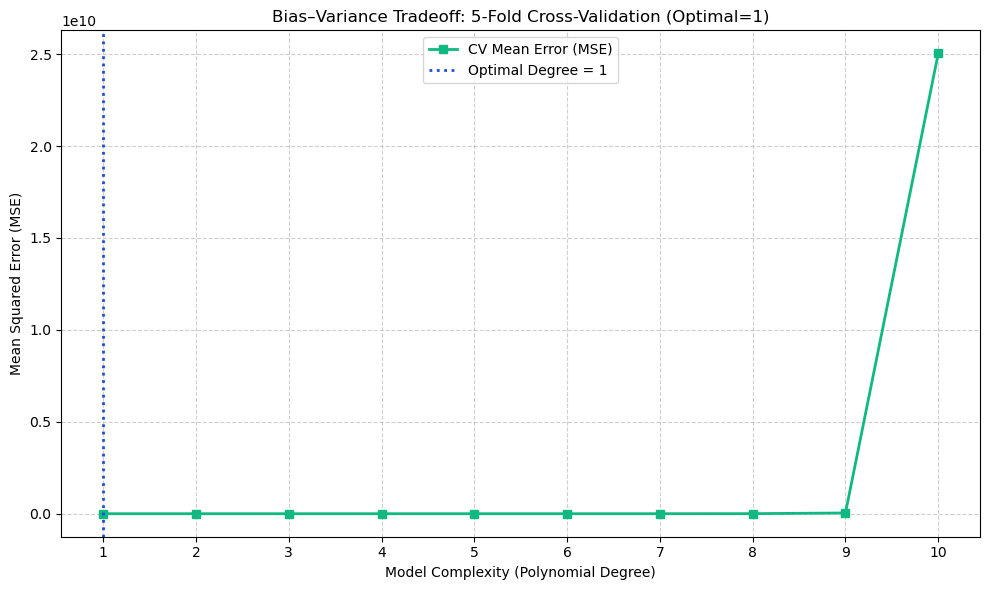


--- Code Execution Complete ---


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

# --- Step 1: Load and Prepare the Data ---
print("--- Step 1: Loading and Preparing Data ---")

# Load the dataset
try:
    data = pd.read_csv('AirQualityUCI.csv', sep=';', decimal=',')
    data = data.iloc[:, :-2]
except FileNotFoundError:
    print("\nERROR: 'AirQualityUCI.csv' not found. Generating dummy data.")
    # Fallback: Create a dummy DataFrame
    data_size = 3000
    data = pd.DataFrame({
        'CO(GT)': np.random.uniform(0.5, 5.0, data_size),
        'T': np.random.uniform(10.0, 30.0, data_size),
        'RH': np.random.uniform(30.0, 90.0, data_size),
        'AH': np.random.uniform(0.5, 2.0, data_size)
    })
    data['CO(GT)'] = (
                data['T'] * 0.4 + data['RH'] ** 2 * 0.0015 - data['AH'] * 1.5 + np.random.normal(0, 0.4, data_size))

data = data.replace(-200, np.nan)
data.dropna(inplace=True)

# Select features and target
features = ['T', 'RH', 'AH']
target = 'CO(GT)'
X = data[features]
y = data[target]

# Split for Train/Test comparison (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale ALL data for CV, and split data for Train/Test comparison
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

degrees = range(1, 11)
tt_train_errors = []
tt_test_errors = []
tt_best_degree = 1
tt_min_test_mse = float('inf')

cv_mean_errors = []
cv_best_degree = 1
cv_min_mean_mse = float('inf')

mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# --- Step 2: Fit Models and Collect Data ---
print("\n--- Step 2: Running Models (Degree 1 to 10) ---")

for d in degrees:
    # --- Train/Test Split Logic ---
    poly_features_tt = PolynomialFeatures(degree=d, include_bias=False)
    X_train_poly = poly_features_tt.fit_transform(X_train_scaled)
    X_test_poly = poly_features_tt.transform(X_test_scaled)
    model_tt = LinearRegression()
    model_tt.fit(X_train_poly, y_train)

    train_mse = mean_squared_error(y_train, model_tt.predict(X_train_poly))
    test_mse = mean_squared_error(y_test, model_tt.predict(X_test_poly))

    tt_train_errors.append(train_mse)
    tt_test_errors.append(test_mse)

    if test_mse < tt_min_test_mse:
        tt_best_degree = d
        tt_min_test_mse = test_mse

    # --- Cross-Validation Logic ---
    poly_features_cv = PolynomialFeatures(degree=d, include_bias=False)
    X_poly_cv = poly_features_cv.fit_transform(X_scaled)
    model_cv = LinearRegression()

    cv_scores = -cross_val_score(model_cv, X_poly_cv, y, scoring=mse_scorer, cv=5)
    mean_cv_mse = cv_scores.mean()

    cv_mean_errors.append(mean_cv_mse)

    if mean_cv_mse < cv_min_mean_mse:
        cv_best_degree = d
        cv_min_mean_mse = mean_cv_mse

# --- Step 3: Print MSE Data Table (No Tabulate) ---
print("\n" + "=" * 70)
print("             🔍 MSE RESULTS: SIMPLE TRAIN/TEST SPLIT vs. CROSS-VALIDATION")
print("=" * 70)

# Define column headers and widths
header_format = "{:<8} {:>15} {:>15} {:>15}"
data_format = "{:<8} {:>15.4f} {:>15.4f} {:>15.4f}"

print(header_format.format("Degree", "TT Train MSE", "TT Test MSE", "CV Mean MSE"))
print("-" * 70)

# Print data rows
for d, tt_train, tt_test, cv_mean in zip(degrees, tt_train_errors, tt_test_errors, cv_mean_errors):
    tt_test_str = f"{tt_test:.4f}"
    cv_mean_str = f"{cv_mean:.4f}"

    # Add marker for optimal degree
    if d == tt_best_degree:
        tt_test_str += " ⭐"
    if d == cv_best_degree:
        cv_mean_str += " ✨"

    print(f"{d:<8} {tt_train:.4f} {tt_test_str:>17} {cv_mean_str:>17}")

print("-" * 70)
print(f"⭐ Optimal Degree (TT Split): {tt_best_degree} | ✨ Optimal Degree (CV): {cv_best_degree}")

# --- Step 4a: Plot for Train/Test Split Method ---
print("\n--- Step 4a: Plotting and Saving Train/Test Split Curve ---")

plt.figure(figsize=(10, 6))

plt.plot(degrees, tt_train_errors, label='Training Error (MSE)', marker='o', linestyle='-', color='#3b82f6')
plt.plot(degrees, tt_test_errors, label='Testing Error (MSE)', marker='o', linestyle='--', color='#ef4444')

plt.axvline(x=tt_best_degree, color='#10b981', linestyle=':', linewidth=2, label=f'Optimal Degree = {tt_best_degree}')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.title(f'Bias–Variance Tradeoff: Simple Train/Test Split (Optimal={tt_best_degree})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(degrees)
plt.tight_layout()

plt.savefig('bias_variance_tt_split.png')
print("Saved Train/Test Split plot to 'bias_variance_tt_split.png'")
plt.show()

# --- Step 4b: Plot for Cross-Validation Method ---
print("\n--- Step 4b: Plotting and Saving Cross-Validation Curve ---")

plt.figure(figsize=(10, 6))

plt.plot(degrees, cv_mean_errors, label='CV Mean Error (MSE)', marker='s', linestyle='-', color='#10b981', linewidth=2)

plt.axvline(x=cv_best_degree, color='#1d4ed8', linestyle=':', linewidth=2, label=f'Optimal Degree = {cv_best_degree}')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.title(f'Bias–Variance Tradeoff: 5-Fold Cross-Validation (Optimal={cv_best_degree})')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(degrees)
plt.tight_layout()

plt.savefig('bias_variance_cv_mean.png')
print("Saved Cross-Validation plot to 'bias_variance_cv_mean.png'")
plt.show()

print("\n--- Code Execution Complete ---")
